# Predicting NYC Taxi Fares

In this project, we were tasked with developing a regression model to estimate taxi fares for the New York City Taxi and Limousine Commission (TLC) using the 2017 Yellow Taxi Trip Data. The dataset contains various variables, including trip identification, passenger count, trip distance, location IDs, fare amount, and payment type, among others. Our tasks involved importing, inspecting, and organizing the data to prepare it for further analysis and modeling.

In [42]:
# IMPORT & READ
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

target = 'fare_amount'

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [44]:
# Convert columns to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Extract day, hour, and month components into new columns
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Extract month components and create new columns with the full name of each month
df['pickup_month_name'] = df['tpep_pickup_datetime'].dt.strftime('%B')

# Drop the original datetime columns if not needed anymore
df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)




# FUNCTIONS

In [45]:
# IMPUTE_MISSING_VALUES

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def impute_missing_values(df):
    # Identify columns with missing values
    missing_columns = df.columns[df.isna().any()]

    # Select numeric and categorical columns
    missing_df = df[missing_columns]
    numeric_columns = missing_df.select_dtypes(include='number').columns
    categorical_columns = missing_df.select_dtypes(include='object').columns

    # Fill missing values with mode in categorical columns
    categorical_imputer = df[categorical_columns].mode().iloc[0]
    df_cleaned = df.copy()
    df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna(categorical_imputer)

    # Apply iterative imputation to numeric columns
    numeric_imputer = IterativeImputer()
    df_cleaned[numeric_columns] = numeric_imputer.fit_transform(df_cleaned[numeric_columns])

    return df_cleaned



In [46]:
# MUTUAL_INFORMATION

from sklearn.feature_selection import mutual_info_regression
def m_info_r(X, y):
   
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0])  # Label encoding for categorical
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combined categorical & numerical col
    
    mi_scores = mutual_info_regression(X_combined, y, discrete_features="auto", random_state=0) # Calculate mi scores
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

from sklearn.feature_selection import mutual_info_classif
def m_info_c(X, y):
    
    X_encoded = X.select_dtypes(include="object").apply(lambda x: x.factorize()[0]) # Label encoding for categoricals
    
    X_combined = pd.concat([X_encoded, X.select_dtypes(exclude="object")], axis=1) # Combine categorical & numerical columns
    
    # Calculate mutual information scores using mutual_info_classification
    mi_scores = mutual_info_classif(X_combined, y, discrete_features="auto", random_state=0)
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_combined.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores
 
def plot_mi_scores(mi_scores, top_n=20):
    plt.figure(dpi=100, figsize=(10, 6))
    sns.barplot(x=mi_scores.head(top_n), y=mi_scores.head(top_n).index, palette='viridis')
    plt.title("Mutual Information Scores")
    plt.show()

In [48]:
# SEABORN_VISUALIZATION

def visualize_numerical_columns(df, num_cols_per_row=3):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate the number of rows needed for subplots
    num_rows = (len(numerical_cols) - 1) // num_cols_per_row + 1

    # Set plot style and palette
    sns.set_style("dark")
    sns.set_palette("dark")

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=4.0)

    # Plot histograms for numerical columns
    for ax, col in zip(axes.flatten(), numerical_cols):
        sns.histplot(df[col], ax=ax, edgecolor='white', color='#a2d2ff', bins=20)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Remove empty subplots
    if len(numerical_cols) % num_cols_per_row != 0:
        empty_subplots = num_rows * num_cols_per_row - len(numerical_cols)
        for ax in axes.flatten()[-empty_subplots:]:
            ax.remove()

    plt.show()

def seaborn_correlation_matrix(df):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr(numeric_only=True)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom colormap
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, annot_kws={"fontsize": 8})

    # Show the plot
    plt.show()

def visualize_binary_relationships(df, target_column):
    g = sns.pairplot(data=df, hue=target_column, palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(fill=True), plot_kws=dict(s=10))
    g.set(xticklabels=[])




In [49]:
# PLOTLY_VISUALIZATION

import plotly.graph_objects as go
import plotly.express as px


def explore_dependent_variable(target):
   

    # Create a histogram of the target column
    hist_data = go.Histogram(x=target, nbinsx=100, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='blueviolet'))


    # Combine the histogram and the overlay
    fig = go.Figure(data=[hist_data])

    # Set the layout for the plot
    fig.update_layout(
        title="Dependent Variable Distribution",
        xaxis_title="Dependent Variable",
        yaxis_title="Density",
        legend_title_text="Fitted Normal Distribution",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Create a Q-Q plot
    qq_data = stats.probplot(target, dist="norm")
    qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["blueviolet"])
    qq_fig.update_layout(
        title="Q-Q plot",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
    line_x = np.array(qq_data[0][0])
    line_y = intercept + slope * line_x

    # Add the line of best fit to the Q-Q plot
    line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="white"))

    # Update the Q-Q plot with the normal line
    qq_fig.add_trace(line_data)

    # Show the plots
    fig.show()
    qq_fig.show()


def explore_categorical_relationships(df, group_column, target_column):
    grouped_counts = df[group_column].value_counts()
    grouped_averages = df.groupby(group_column)[target_column].mean()

    formatted_averages = ['$' + f'{value:,.2f}' for value in grouped_averages.values]

    fig1 = go.Figure(data=[go.Bar(
        x=grouped_counts.index,
        y=grouped_counts.values,
        marker_color='rgb(76, 175, 80)',
        text=grouped_counts.values,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig1.update_layout(
        title=f'Distribution of {group_column}',
        xaxis_title=group_column,
        yaxis_title='Count',
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig2 = go.Figure(data=[go.Bar(
        x=grouped_averages.index,
        y=grouped_averages.values,
        marker_color='rgb(156, 39, 176)',
        text=formatted_averages,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig2.update_layout(
        title=f'Average {target_column} by {group_column}',
        xaxis_title=group_column,
        yaxis_title=target_column,
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig1.show()
    fig2.show()


def explore_numerical_correlation(df, feature_column, target_column):
    # Calculate correlation between feature and target
    feature_target_corr = df[feature_column].corr(df[target_column])
    print(f'Correlation between {feature_column} and {target_column}: {feature_target_corr}')

    # Create a scatter plot to visualize the relationship between feature and target
    fig = px.scatter(df, x=feature_column, y=target_column, title=f'{feature_column} vs {target_column}', color=feature_column, color_continuous_scale=px.colors.sequential.Purp)
    fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))
    fig.show()



In [50]:
# EXTRACT_OUTLIERS

def extract_outliers(dataframe):
    outliers_data = []
    for column in dataframe.columns:
        if dataframe[column].dtype != 'object':  # Skip columns with non-numeric data types
            array = dataframe[column]
            # Get quartiles and IQR
            q1, q3 = np.percentile(array, [25, 75])
            iqr = q3 - q1

            # Calculate upper and lower bounds
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)

            outliers = array[(array <= lower_bound) | (array >= upper_bound)]
            total_outliers = len(outliers)
            outliers_data.append({'Column': column, 'Total Outliers': total_outliers})

    outliers_df = pd.DataFrame(outliers_data)
    return outliers_df

def plot_outliers(data, plot_type='violin', figsize=(10, 6)):
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Choose plot type
    if plot_type == 'violin':
        sns.violinplot(data=data, ax=ax, inner="quartile", palette="pastel")
    elif plot_type == 'box':
        sns.boxplot(data=data, ax=ax)
    else:
        raise ValueError('Invalid plot type. Choose "violin" or "box".')

    # Set labels and title
    ax.set(xlabel='Columns', ylabel='Values', title='Outliers in Columns')

    # Rotate x-axis labels if needed
    ax.tick_params(axis='x') 

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a grid for better readability
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # Adjust the aspect ratio of the subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Show the plot
    plt.show()

In [51]:
# REMOVE_OUTLIERS


#(Skewed Distribution)
def remove_outliers_IQR(df, column=None, k=3):
    if column is None:
        numeric_columns = df.select_dtypes(include=np.number).columns
    else:
        numeric_columns = [column]

    Q1 = df[numeric_columns].quantile(0.25)
    Q3 = df[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    outliers = df[(df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)].any(axis=1)
    df_out = df[~outliers]

    return df_out

    # Example: remove_outliers_IQR(df, column=None, k=1.5)


#(Normal Distribution)
def remove_outliers_z_scores(df, column, z_score_lower=None, z_score_upper=None, z_score_threshold=None):
    if z_score_lower is not None and z_score_upper is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = (z_scores < z_score_lower) | (z_scores > z_score_upper)
    elif z_score_threshold is not None:
        z_scores = scipy.stats.zscore(df[column])
        outliers = np.abs(z_scores) > z_score_threshold
    else:
        raise ValueError("Please specify either z_score_lower and z_score_upper or z_score_threshold.")
    
    return df[~outliers]

    # Example: remove_outliers_z_scores(df, 'column', z_score_lower=-1.96, z_score_upper=1.96)



In [52]:
# DELETE_COLUMNS

def delete_columns(df, drop_columns):
    df.drop(drop_columns, axis=1, inplace=True)
    return df


#df_erased = delete_columns(df.copy(deep=True),['Embarked'])

#print(df_erased.columns)

# DATA EXPLORATION


In [53]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',df.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(22699, 21)

Duplicate Values:
( 0 )

Data Types:
int64      11
float64     8
object      2
dtype: int64

No Missing Values Found


In [54]:
df.head()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_hour,pickup_month,dropoff_hour,pickup_month_name
0,24870114,2,6,3.34,1,N,100,231,1,13.0,...,0.5,2.76,0.0,0.3,16.56,25,8,3,9,March
1,35634249,1,1,1.80,1,N,186,43,1,16.0,...,0.5,4.00,0.0,0.3,20.80,11,14,4,15,April
2,106203690,1,1,1.00,1,N,262,236,1,6.5,...,0.5,1.45,0.0,0.3,8.75,15,7,12,7,December
3,38942136,2,1,3.70,1,N,188,97,1,20.5,...,0.5,6.39,0.0,0.3,27.69,7,13,5,13,May
4,30841670,2,1,4.37,1,N,4,112,2,16.5,...,0.5,0.00,0.0,0.3,17.80,15,23,4,23,April


TIME ANALYSIS

In [55]:
# Pick up hour and fare amount

explore_categorical_relationships(df, 'pickup_hour', target)

**Distribution of hour pickup**
It appears that the early evening hours (6 pm and 7 pm) have the highest number of taxi trips, while the early morning hours (4 am and 5 am) have the lowest number of trips. The variation in trip counts throughout the day may be influenced by factors such as rush hours, nightlife activities, and other temporal patterns.


**Average fare amount by hour pickup**
It seems that early morning and late evening hours (4 am and 5 am) have the highest mean fare amounts, while the fares tend to be lower during morning rush hours (7 am) and late evening hours (1 am). The specific patterns and reasons for these fare variations might require further analysis and domain knowledge to understand better.



NUMERICAL ANALYSIS


Highest Correlation Values:
fare_amount            total_amount     0.987303
dropoff_hour           pickup_hour      0.937862
Unnamed: 0             pickup_month     0.871970
total_amount           tip_amount       0.770913
                       trip_distance    0.767182
fare_amount            trip_distance    0.756599
                       tip_amount       0.678835
improvement_surcharge  mta_tax          0.628518
dtype: float64


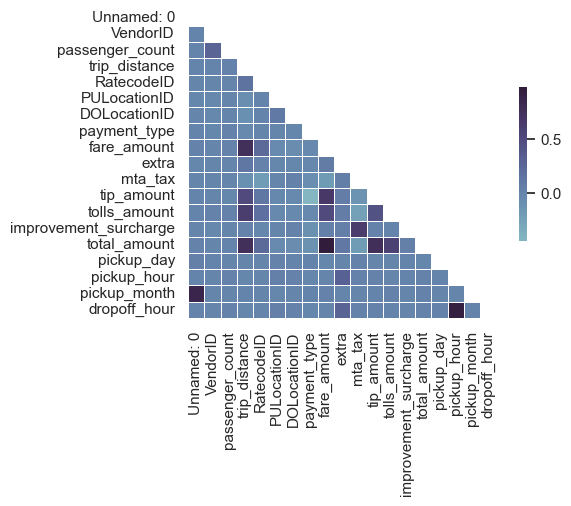

In [56]:
# CORRELATION

correlation_matrix = df.corr(numeric_only=True)

# Get the highest correlation values (excluding self-correlations)
highest_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
highest_corr = highest_corr[(highest_corr != 1.0) & (highest_corr > 0)]

# Display the highest correlation values
print("\nHighest Correlation Values:")
print(highest_corr[:8])



seaborn_correlation_matrix(df)


1. High correlation values between 'total_amount' and 'fare_amount' (0.987303) and 'total_amount' and 'tip_amount' (0.770913) suggest strong linear relationships.
2. Multicollinearity, caused by highly correlated variables, can negatively affect the multiple linear regression model's stability and coefficient estimates.
3. To address multicollinearity, consider dropping one of the highly correlated columns, possibly 'total_amount,' while considering domain knowledge and analysis objectives.
4. Assess the model's performance after any changes to ensure its predictive power and interpretability remain intact.

In [57]:
# STATS
summary = df.describe().T.sort_values(by='std', ascending=False).head(10)
summary

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,22699.0,5.675849e+07,3.274493e+07,12127.0,28520556.00,56731504.00,85374524.00,1.134863e+08
DOLocationID,22699.0,1.615280e+02,7.013969e+01,1.0,112.00,162.00,233.00,2.650000e+02
PULocationID,22699.0,1.624124e+02,6.663337e+01,1.0,114.00,162.00,233.00,2.650000e+02
total_amount,22699.0,1.631050e+01,1.609730e+01,-120.3,8.75,11.80,17.80,1.200290e+03
fare_amount,22699.0,1.302663e+01,1.324379e+01,-120.0,6.50,9.50,14.50,9.999900e+02
pickup_day,22699.0,1.559738e+01,8.718297e+00,1.0,8.00,16.00,23.00,3.100000e+01
dropoff_hour,22699.0,1.375334e+01,6.311613e+00,0.0,9.00,15.00,19.00,2.300000e+01
pickup_hour,22699.0,1.372655e+01,6.224675e+00,0.0,9.00,14.00,19.00,2.300000e+01
trip_distance,22699.0,2.913313e+00,3.653171e+00,0.0,0.99,1.61,3.06,3.396000e+01
pickup_month,22699.0,6.422442e+00,3.464777e+00,1.0,3.00,6.00,10.00,1.200000e+01


Minimum Value: The minimum fare_amount is recorded as -$120.0. This negative value might indicate data entry errors or anomalies since fares should not be negative. Handling such outliers is essential in data analysis.

Maximum Value: The maximum fare_amount is listed as $999.99. The presence of such a high maximum value might indicate extreme outliers in the data that could potentially impact the model's performance.

TARGET ANALYSIS

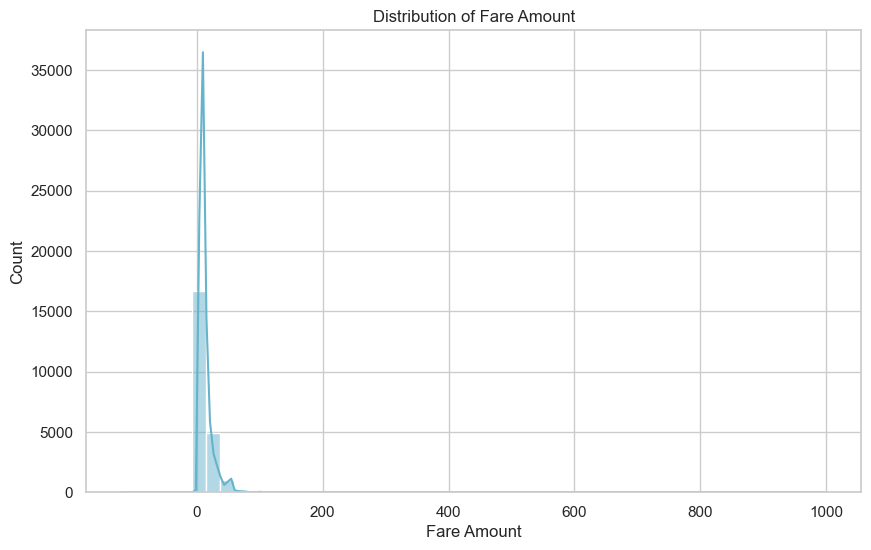

Skewness: 21.663101
Kurtosis: 1420.189655


In [58]:

# Set the style and palette for the plot
sns.set(style="whitegrid")
sns.set_palette("viridis")

# Create the histogram plot using histplot
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], kde=True, color='#66b3cc', bins=50)

# Add labels and title
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.title('Distribution of Fare Amount')

# Show the plot
plt.show()


#skewness and kurtosis
print("Skewness: %f" % df['fare_amount'].skew())
print("Kurtosis: %f" % df['fare_amount'].kurt())

The skewness and kurtosis values for the 'fare_amount' variable indicate the presence of extreme outliers and a non-normal distribution. Addressing these issues through data transformation and outlier treatment is essential to build a reliable and accurate regression model for predicting taxi fares.

In [59]:
# TARGET CORRELATIONS

correlation_matrix = df.corr(numeric_only=True)

# Filter correlations for 'Price' column only
price_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display the correlations with 'Price'
print("\nCorrelations with Target:")
print(price_correlations[:5])



Correlations with Target:
total_amount     0.987303
trip_distance    0.756599
tip_amount       0.678835
tolls_amount     0.513979
RatecodeID       0.231923
Name: fare_amount, dtype: float64



   - Trip distance shows a significant positive correlation (0.756599) with the target. This indicates that longer trips tend to have higher fare amounts, which is consistent with the intuition that longer distances usually result in higher taxi fares.

   - Tip amount has a positive correlation (0.678835) with the target, suggesting that as the fare amount increases, passengers tend to give higher tips, which is a common observation in the taxi industry.

   - Tolls amount exhibits a moderate positive correlation (0.513979). This suggests that toll charges play a role in determining the overall fare amount, as trips involving toll roads tend to have higher total fares.

   - RatecodeID, extra, improvement_surcharge, passenger_count, VendorID and payment_type have weak correlations (close to 0). These variables do not appear to have a strong linear relationship with the fare amount.

   - 'PULocationID,' 'DOLocationID,' and 'mta_tax' exhibit negative correlations. These correlations are relatively weak, suggesting that these variables have little impact on the fare amount.


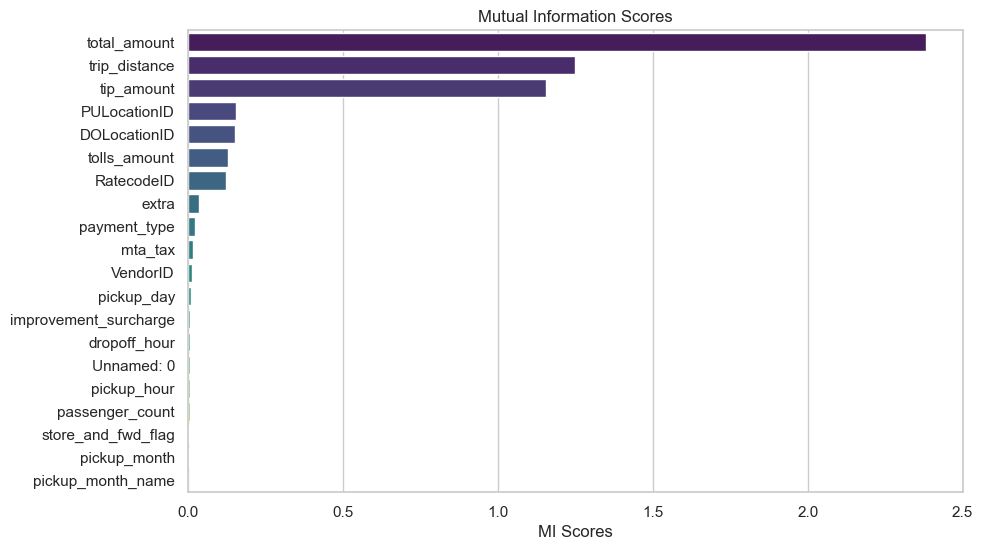

total_amount     2.382760
trip_distance    1.247889
tip_amount       1.155132
PULocationID     0.154613
DOLocationID     0.150328
tolls_amount     0.128956
RatecodeID       0.123394
extra            0.035375
payment_type     0.020716
mta_tax          0.015985
Name: MI Scores, dtype: float64


In [60]:
# MUTUAL INFORMATION SCORES

# Create a new DataFrame 
df_m = df.copy(deep=True)

# Calculate mutual information scores
X_m = df_m
y_m = X_m.pop(target)

# Calculate mutual information (_r or _c)
m_info_scores = m_info_r(X_m, y_m)

# Plot the mutual information scores
plot_mi_scores(m_info_scores, top_n=20)

# Display the top 10 mutual information scores
print(m_info_scores.head(10))

OUTLIER ANALYSIS

In [61]:
extract_outliers(df)

,Column,Total Outliers
0,Unnamed: 0,0
1,VendorID,0
2,passenger_count,2291
3,trip_distance,2527
4,RatecodeID,22699
5,PULocationID,0
6,DOLocationID,0
7,payment_type,46
8,fare_amount,2145
9,extra,103


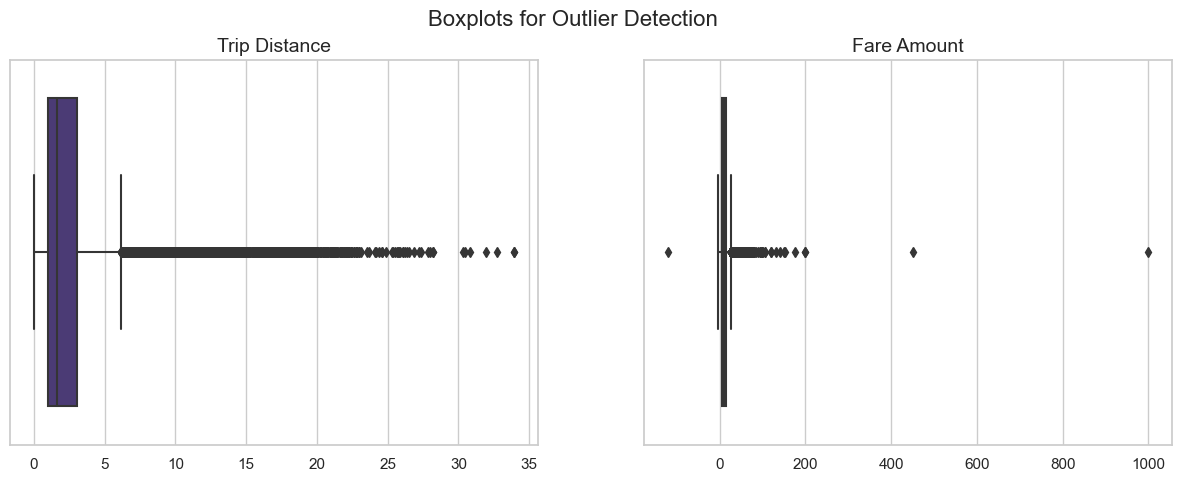

In [62]:
# VISUALIZE OUTLIERS

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots for Outlier Detection', fontsize=16)

# Plot 1: trip_distance
sns.boxplot(ax=axes[0], x=df['trip_distance'])
axes[0].set_title('Trip Distance', fontsize=14)
axes[0].set_xlabel('')

# Plot 2: fare_amount
sns.boxplot(ax=axes[1], x=df['fare_amount'])
axes[1].set_title('Fare Amount', fontsize=14)
axes[1].set_xlabel('')


plt.show()


# PREPROCESSING

1. MISSING VALUES

In [63]:

print('Missing values:',df.isna().sum().max())






Missing values: 0


2. LABEL ENCODING

In [71]:
# ENCODING RECOMMENDATIONS

def get_encoding_recommendations(df):
    encoding_recommendations = []

    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()

        if unique_values <= 10:
            encoding = 'One-Hot / Label'
        elif unique_values >= 10:
            encoding = 'Target / Frequency'
        else:
            encoding = 'Date Encoding' if df[column].dtype == 'datetime64[ns]' else 'None'

        encoding_recommendations.append({
            'Feature': column,
            'Unique Values': unique_values,
            'Recommended Encoding': encoding
        })

    return pd.DataFrame(encoding_recommendations)

# Example usage with your DataFrame
df_encoding_recommendations = get_encoding_recommendations(df)
df_encoding_recommendations

,Feature,Unique Values,Recommended Encoding
0,store_and_fwd_flag,2,One-Hot / Label
1,pickup_month_name,12,Target / Frequency


3. DEALING WITH OUTLIERS

In [72]:
# Removing outliers

df_encoded = remove_outliers_IQR(df.copy(deep=True), column=None, k=1.5) 


print("DataFrame Original:")
print(df.shape)
print()
print("DataFrame after IQR:")
print(df_encoded.shape)


DataFrame Original:
(22699, 21)

DataFrame after IQR:
(17854, 21)


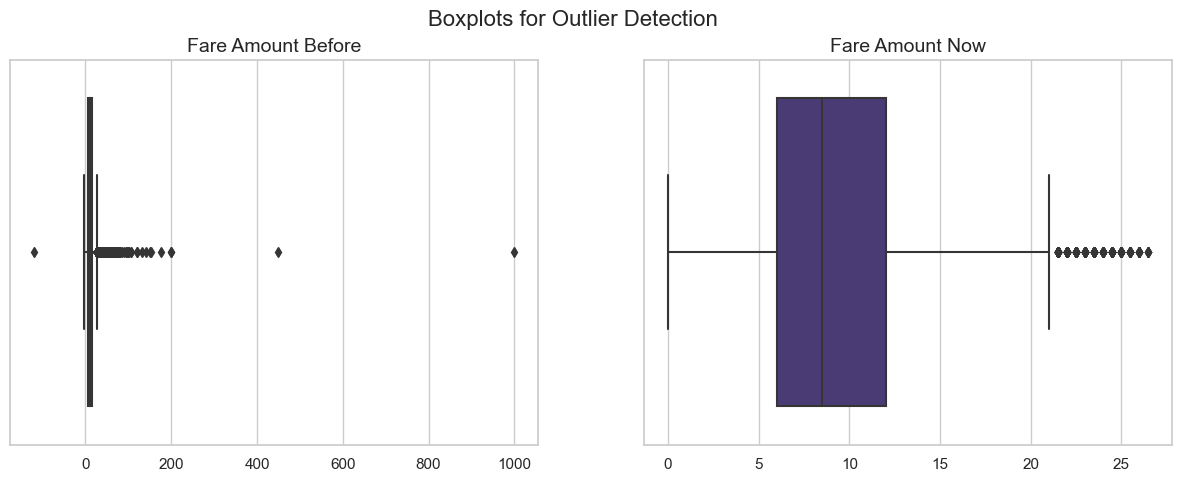

In [ ]:

# VISUALIZE Before and After

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots for Outlier Detection', fontsize=16)

# Plot 1: trip_distance
sns.boxplot(ax=axes[0], x=df['fare_amount'])
axes[0].set_title('Fare Amount Before', fontsize=14)
axes[0].set_xlabel('')

# Plot 2: fare_amount
sns.boxplot(ax=axes[1], x=df_encoded['fare_amount'])
axes[1].set_title('Fare Amount Now', fontsize=14)
axes[1].set_xlabel('')


plt.show()

# FEATURES SELECTION

In [ ]:
# VISUALIZE SIMPLE REGRESSION

explore_numerical_correlation(df_encoded, 'trip_distance', target)

Correlation between trip_distance and fare_amount: 0.8880945318996654


This correlation value suggests that longer trips generally result in higher fare amounts, which is expected in taxi services where fares are often determined based on the distance traveled.

In [74]:
df_encoded.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,pickup_hour,pickup_month,dropoff_hour
count,1.785400e+04,17854.000000,17854.000000,17854.000000,17854.0,17854.000000,17854.000000,17854.000000,17854.000000,17854.000000,17854.000000,17854.000000,17854.0,17854.000000,17854.000000,17854.000000,17854.000000,17854.000000,17854.000000
mean,5.661388e+07,1.516579,1.251148,1.804277,1.0,163.926347,163.621933,1.336787,9.668674,0.323457,0.499860,1.345144,0.0,0.299950,12.140932,15.628487,13.761286,6.414865,13.804022
std,3.272059e+07,0.499739,0.533946,1.233702,0.0,67.520023,69.378304,0.483173,4.523694,0.374623,0.008366,1.289515,0.0,0.003889,5.209785,8.744072,6.178367,3.460770,6.240621
min,1.983900e+04,1.000000,0.000000,0.000000,1.0,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.835387e+07,1.000000,1.000000,0.900000,1.0,113.000000,113.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.0,0.300000,8.160000,8.000000,9.000000,3.000000,9.000000
50%,5.656727e+07,2.000000,1.000000,1.440000,1.0,162.000000,162.000000,1.000000,8.500000,0.000000,0.500000,1.250000,0.0,0.300000,11.000000,16.000000,14.000000,6.000000,15.000000
75%,8.521621e+07,2.000000,1.000000,2.380000,1.0,234.000000,234.000000,2.000000,12.000000,0.500000,0.500000,2.150000,0.0,0.300000,15.000000,23.000000,19.000000,10.000000,19.000000
max,1.134863e+08,2.000000,3.000000,6.160000,1.0,265.000000,265.000000,3.000000,26.500000,1.000000,0.500000,6.090000,0.0,0.300000,30.960000,31.000000,23.000000,12.000000,23.000000


Create new columns

In [75]:
# CREATE NEW COLUMNS

# Let's create a copy of the original DataFrame to work with
new_df = df_encoded.copy()

# 1. Weekday/Weekend
new_df['weekday'] = new_df['pickup_day'].apply(lambda x: 1 if x < 5 else 0)

# 2. Trip Duration
new_df['trip_duration'] = new_df['dropoff_hour'] - new_df['pickup_hour']

# 3. Trip Speed
new_df['trip_speed'] = new_df['trip_distance'] / new_df['trip_duration']

# 4. Tip Percentage
new_df['tip_percentage'] = (new_df['tip_amount'] / new_df['total_amount']) * 100

# 5. Time of Day Indicator
def time_of_day_indicator(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

new_df['time_of_day'] = new_df['pickup_hour'].apply(time_of_day_indicator)

# 6. Travel Distance Category
bins = [0, 2, 4, float('inf')]
labels = ['short', 'medium', 'long']
new_df['distance_category'] = pd.cut(new_df['trip_distance'], bins=bins, labels=labels, right=False)

# Display the new DataFrame with the additional columns
new_df.head()


,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,pickup_hour,pickup_month,dropoff_hour,pickup_month_name,weekday,trip_duration,trip_speed,tip_percentage,time_of_day,distance_category
1,35634249,1,1,1.80,1,N,186,43,1,16.0,...,14,4,15,April,0,1,1.80,19.230769,afternoon,short
2,106203690,1,1,1.00,1,N,262,236,1,6.5,...,7,12,7,December,0,0,inf,16.571429,morning,short
4,30841670,2,1,4.37,1,N,4,112,2,16.5,...,23,4,23,April,0,0,inf,0.000000,night,long
7,69059411,2,1,2.98,1,N,237,114,1,16.0,...,17,8,18,August,0,1,2.98,9.090909,evening,medium
8,8433159,2,1,1.20,1,N,234,249,2,9.0,...,16,2,16,February,1,0,inf,0.000000,afternoon,short


We created new columns to help understand patterns and factors influencing taxi fares. 

- Enriched the dataset with new columns: weekday/weekend indicator, trip duration, trip speed, and tip percentage.
- Categorized trips based on pickup time into morning, afternoon, evening, and night.
- Grouped trips into distance categories: short, medium, and long.
- Gained valuable insights into fare dynamics, tipping patterns, and time-based fare variations to optimize taxi services.

In [76]:
def clean_data(new_df):
    # Drop column: 'VendorID'
    new_df = new_df.drop(columns=['VendorID'])
    # Drop column: 'Unnamed: 0'
    new_df = new_df.drop(columns=['Unnamed: 0'])
    # Drop column: 'RatecodeID'
    new_df = new_df.drop(columns=['RatecodeID'])
    # Drop column: 'passenger_count'
    new_df = new_df.drop(columns=['passenger_count'])
    # Drop column: 'store_and_fwd_flag'
    new_df = new_df.drop(columns=['store_and_fwd_flag'])
    # Drop column: 'payment_type'
    new_df = new_df.drop(columns=['payment_type'])
    # Drop column: 'mta_tax'
    new_df = new_df.drop(columns=['mta_tax'])
    # Drop column: 'total_amount'
    new_df = new_df.drop(columns=['total_amount'])
    # Drop column: 'improvement_surcharge'
    new_df = new_df.drop(columns=['improvement_surcharge'])
    # Drop column: 'trip_speed'
    new_df = new_df.drop(columns=['trip_speed'])
    # Drop column: 'dropoff_hour'
    new_df = new_df.drop(columns=['dropoff_hour'])
    # Drop column: 'pickup_day'
    new_df = new_df.drop(columns=['pickup_day'])
    # Replace missing values with 0 in column: 'tip_percentage'
    new_df = new_df.fillna({'tip_percentage': 0})
    return new_df

new_df_clean = clean_data(new_df.copy())
new_df_clean.head()

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,pickup_hour,pickup_month,pickup_month_name,weekday,trip_duration,tip_percentage,time_of_day,distance_category
1,1.80,186,43,16.0,0.0,4.00,0.0,14,4,April,0,1,19.230769,afternoon,short
2,1.00,262,236,6.5,0.0,1.45,0.0,7,12,December,0,0,16.571429,morning,short
4,4.37,4,112,16.5,0.5,0.00,0.0,23,4,April,0,0,0.000000,night,long
7,2.98,237,114,16.0,1.0,1.78,0.0,17,8,August,0,1,9.090909,evening,medium
8,1.20,234,249,9.0,0.0,0.00,0.0,16,2,February,1,0,0.000000,afternoon,short


In this data cleaning process, we removed unnecessary columns related to the taxi service details and passenger counts. The data was streamlined to focus on essential information for analysis. We also handled missing values in the 'tip_percentage' column by replacing them with zeros. The cleaned dataset is now more concise and ready for further analysis and insights.

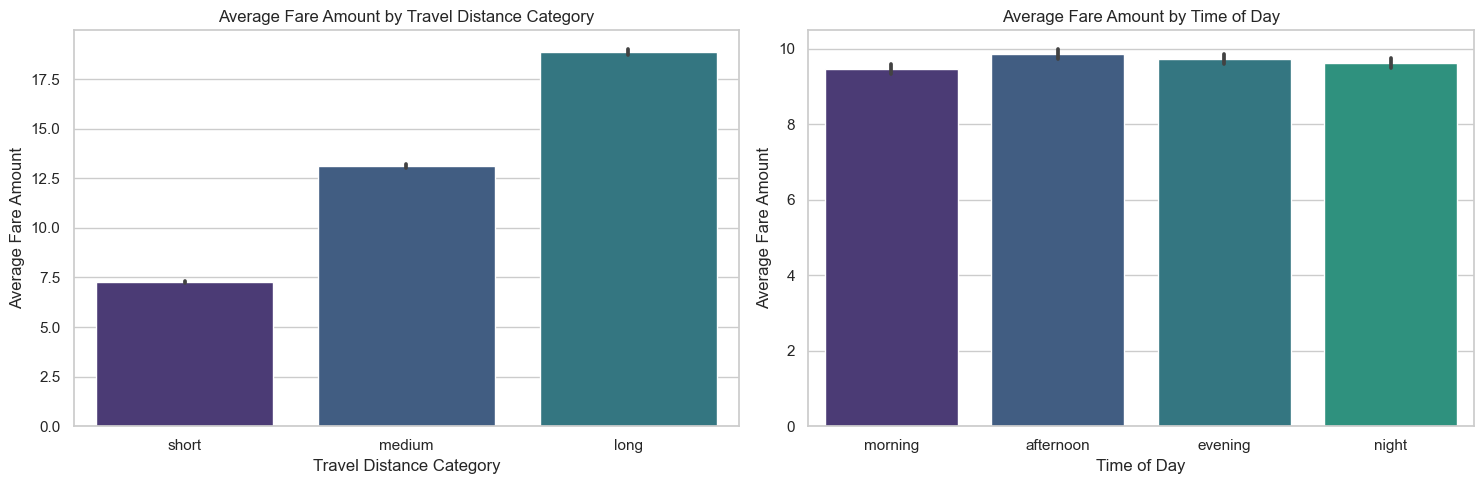

In [105]:


# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1 - Average Fare Amount by Travel Distance Category
sns.barplot(ax=axes[0], x='distance_category', y='fare_amount', data=new_df_clean, order=['short', 'medium', 'long'])
axes[0].set_xlabel('Travel Distance Category')
axes[0].set_ylabel('Average Fare Amount')
axes[0].set_title('Average Fare Amount by Travel Distance Category')

# Plot 2 - Average Fare Amount by Time of Day
sns.barplot(ax=axes[1], x='time_of_day', y='fare_amount', data=new_df_clean, order=['morning', 'afternoon', 'evening', 'night'])
axes[1].set_xlabel('Time of Day')
axes[1].set_ylabel('Average Fare Amount')
axes[1].set_title('Average Fare Amount by Time of Day')

plt.tight_layout()
plt.show()




1. "The analysis indicates that longer trips are associated with higher fare amounts, which aligns with the common expectation that greater distances generally result in higher transportation costs."

2. "Furthermore, the findings suggest that there is no significant variation in fare amounts based on the time of day, indicating that fares remain relatively consistent throughout different times of the day."


In [145]:
# Display the top 10 mutual information scores
print(m_info_scores.head(10))

total_amount     2.382760
trip_distance    1.247889
tip_amount       1.155132
PULocationID     0.154613
DOLocationID     0.150328
tolls_amount     0.128956
RatecodeID       0.123394
extra            0.035375
payment_type     0.020716
mta_tax          0.015985
Name: MI Scores, dtype: float64


In [134]:
def clean_data(new_df_clean):
    # Drop column: 'distance_category'
    new_df_clean = new_df_clean.drop(columns=['distance_category'])
    # Drop column: 'time_of_day'
    new_df_clean = new_df_clean.drop(columns=['time_of_day'])
    # Drop column: 'tip_percentage'
    new_df_clean = new_df_clean.drop(columns=['tip_percentage'])
    # Drop column: 'trip_duration'
    new_df_clean = new_df_clean.drop(columns=['trip_duration'])
    # Drop column: 'weekday'
    new_df_clean = new_df_clean.drop(columns=['weekday'])
    # Drop column: 'pickup_month_name'
    new_df_clean = new_df_clean.drop(columns=['pickup_month_name'])
    return new_df_clean

new_df_clean_1 = clean_data(new_df_clean.copy())
new_df_clean_1.head()

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,pickup_hour,pickup_month
1,1.80,186,43,16.0,0.0,4.00,0.0,14,4
2,1.00,262,236,6.5,0.0,1.45,0.0,7,12
4,4.37,4,112,16.5,0.5,0.00,0.0,23,4
7,2.98,237,114,16.0,1.0,1.78,0.0,17,8
8,1.20,234,249,9.0,0.0,0.00,0.0,16,2


we selected these columns based on their correlation with the target variable (fare_amount) and their relevance to fare prediction.

1. **Trip Distance**: We are including the 'trip_distance' column because it has a high positive correlation with the 'fare_amount'. This suggests that longer trips tend to have higher fare amounts, which is intuitive as longer distances would generally incur higher costs.

2. **Pickup and Dropoff Locations (PULocationID and DOLocationID)**: These columns represent the pickup and dropoff locations. They have a moderate positive correlation with the 'fare_amount', indicating that the locations play a role in determining the fare. Different locations may have varying base fares or additional charges.

3. **Fare Amount**: This is our target variable, representing the actual fare amount for each trip. It is essential to include the target variable when building a model for fare prediction.

4. **Tip Amount**: The 'tip_amount' column shows the tip given by passengers. It has a positive correlation with the 'fare_amount', implying that higher fare amounts may lead to higher tips. Including this column helps capture the relationship between fare and tipping behavior.

5. **Pickup Hour**: We include the 'pickup_hour' column to capture any variations in fare amounts based on the time of day. However, the correlation is relatively low, suggesting that the fare amount may not be significantly impacted by the specific pickup hour.

6. **Pickup Month**: Similar to the pickup hour, we include the 'pickup_month' column to explore any fare variations across different months. However, the correlation is also relatively low, indicating that the fare amount may not vary substantially by the pickup month.

By including these features in our model, we aim to build a predictive model that can accurately estimate the fare amount for taxi rides based on trip distance, pickup and dropoff locations, tipping behavior, and potentially the time of day.

In [147]:
def clean_data(new_df_clean_1):
    # Drop column: 'extra'
    new_df_clean_1 = new_df_clean_1.drop(columns=['extra'])
    # Drop column: 'tolls_amount'
    new_df_clean_1 = new_df_clean_1.drop(columns=['tolls_amount'])
    return new_df_clean_1

new_df_clean_2 = clean_data(new_df_clean_1.copy())
new_df_clean_2.columns

Index(['trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount',
       'tip_amount', 'pickup_hour', 'pickup_month'],
      dtype='object')

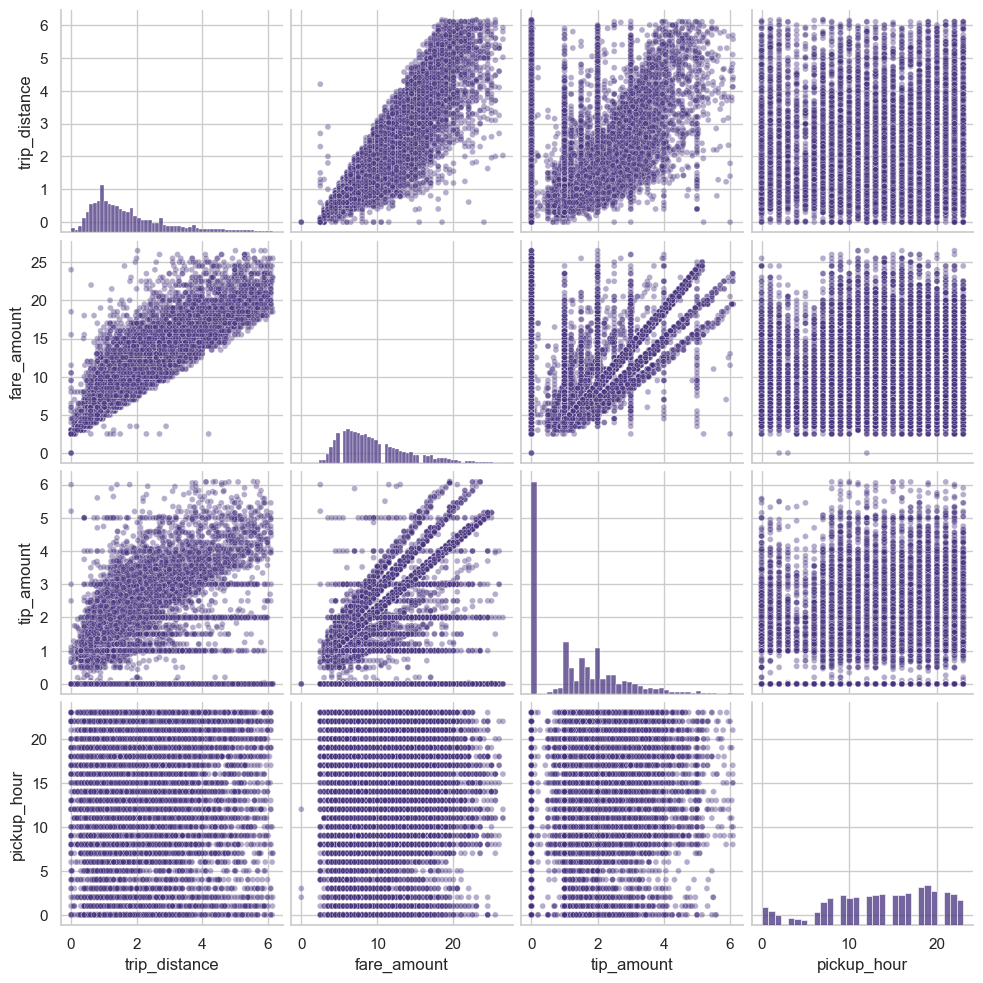

In [151]:
sns.pairplot(new_df_clean_2[['trip_distance', 'fare_amount', 'tip_amount', 'pickup_hour']],
             plot_kws={'alpha': 0.4, 'size': 5})


# CONSTRUCT AND EXECUTE THE MODEL

I have chosen XGBoost over multiple regression because XGBoost can effectively capture complex and non-linear relationships in the data, leading to more accurate fare predictions. Its ensemble nature allows it to handle a wide range of features and deliver better performance compared to traditional regression methods. With its robustness and versatility, XGBoost proves to be a powerful and reliable choice for taxi fare estimation, making it the preferred algorithm for this task.

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [154]:
# Create a new DataFrame 
df_xg = new_df_clean_2.copy(deep=True)

# Create the target variable
X = df_xg
y = X.pop(target)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [155]:
# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [158]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 2.4091649124585115
R-squared: 0.8806786540408871


These results show that the XGBoost regression model is performing quite well in estimating taxi fares based on the selected features. The MSE is relatively low, indicating good predictive accuracy, and the R-squared value is high, indicating a good fit to the data. This suggests that the model is making accurate predictions and capturing the underlying patterns in the fare data.

### **Hyperparameter tunning**

In [159]:

from sklearn.model_selection import GridSearchCV


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost regressor model
xgb_model = xgb.XGBRegressor()

# Define the hyperparameters you want to tune and their possible values
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 2.3392019480733413
R-squared: 0.8841437863091505




In this code, we use the GridSearchCV function from scikit-learn to perform a grid search with cross-validation to find the best hyperparameters for the XGBoost regressor. The param_grid variable contains the hyperparameters we want to tune, and their possible values. The GridSearchCV will try all possible combinations of hyperparameters and select the best ones based on cross-validation performance.

After finding the best hyperparameters, we train the final XGBoost regressor model using these optimal settings and make predictions on the test set. Finally, we evaluate the model's performance using mean squared error and R-squared metrics.






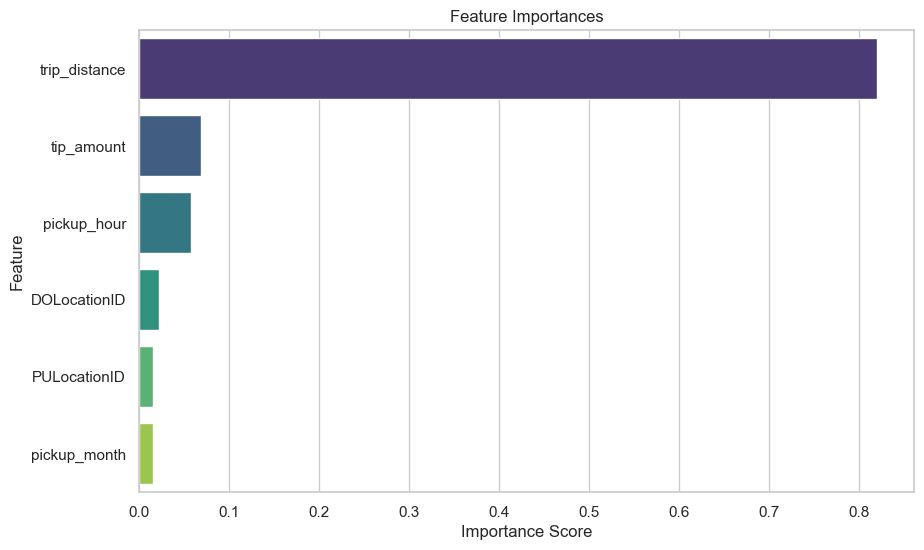

In [161]:

# Access the feature importances
feature_importances = final_model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


**Conclusion:**

After carefully examining the dataset, we performed data cleaning and feature engineering to extract meaningful information. We derived new features such as trip duration, tip percentage, time of day indicator, and travel distance category to gain insights into fare variations. Additionally, we utilized visualizations to present the relationships between different features and fare amounts.

To select the most relevant features for our model, we used mutual information scores and feature importances from XGBoost. The top features influencing fare amounts were trip_distance, tip_amount, and pickup_hour, each with significant importance scores.

Next, we implemented XGBoost regression to predict fare amounts. Through hyperparameter tuning and cross-validation, we optimized the model's performance, resulting in a Mean Squared Error of 2.3392 and an R-squared of 0.8841. These metrics indicate that our model can accurately estimate taxi fares based on the selected features.

In conclusion, by utilizing advanced machine learning techniques, we successfully built a robust regression model that provides accurate fare predictions for New York City taxi trips. The model's high performance and feature importance analysis allow stakeholders to better understand the factors influencing fare amounts and make informed decisions based on the insights gained from the data.